In [56]:
def preprocess(pdf):
    from re import sub
    t = ' '.join(pdf)
    t = sub(r'(https.*\s)' , '', t) 
    t = sub(r'●', ' ', t)
    t = sub(r'⚬', '', t)
    t = sub(r'\n\n', '|||', t)
    t = sub(r'\n', '|||',t)
    t = sub(r'(\d+/\d+/\d+)|(\d+\:\d+)|(\d+/\d+)', ' ',t)
    t = sub(r'(\x0c)', '', t)
    t_lines = t.split('|||')
    t_lines = [line.strip() for line in t_lines if len(line.strip()) > 2]
    for end, line in enumerate(t_lines):
        if sum([(word in line) for word in ['Previous authors','Last reviewed','Guidelines and Resources']]) == True:
            t_lines = t_lines[:end]
            
    #remove studies        
    omit=[]
    stop=0
    for start, line in enumerate(t_lines):
        if ('SUMMARY' in line) == True :
            find=False
            for stop, line in enumerate(t_lines[start:]):
                if('Reference' in line) == True:
                    omit += [i for i in range(start,start+stop+1)]
                    find = True
                    break
            if not find:
                omit+=[i for i in range(start,start+stop+1)]
    
    t_lines = [line for index, line in enumerate(t_lines) if index not in omit]
    omit=[]
    
    #remove refrences
    for num,line in enumerate(t_lines):
        if sum([(word in line) for word in ['Latest change','Reference','Evidence-Based Medicine Guidelines',
                                            'EBM Guidelines', 'Teuvo Tammela']]) == True:
            omit += [num]
    t_lines = [line for index, line in enumerate(t_lines) if index not in omit]
    
    #remove duplicate lines
    t_lines = [ii for n,ii in enumerate(t_lines) if ii not in t_lines[:n]]   
    
    #paragraphs
    headings = ['Complications', 'CLINICIAN', 'DynaMed Commentary', 'Prevention', 'Management',
 'Also called', 'Evaluation', 'Overview', 'Testing', 'Differential', 'Diagnosis', 'Physical', 'History', 'Pathogenesis',
 'Prognosis', 'Screening', 'Etiology', 'Pathogenesis', 'Risk', 'Epidemiology', 'Definitions', 'Description', 'Related Topics',
 'Background', 'Definition', 'pathogenesis', 'Investigations', 'Investigation and treatment strategy', 'Investigation', 'Treatment',
               'pathogenesis', 'Essentials', 'Epidemiology', 'Aetiology', 'Clinical signs', 'Laboratory', 'Symptoms', 'Grading',
               'Drug', 'Principles', 'Pharmacologic prophylaxis', 'Nonpharmacologic prophylaxis', 'Recommendations',
               'Medications', 'Indications', 'Antihypertensives', 'Antidepressants', 'Anticonvulsants', 'Antihistamines',
               'Botulinum', 'Nutraceuticals', 'Riboflavin', 'Nonpharmacologic Therapies', 'Cognitive behavioral therapy',
               'General', 'Primary investigations', 'Non-pharmacological', 'Grade', 'The most common adverse effects', 
               'Efficacy', 'Duration', 'Specific', 'Comparative', 'American', 'Transmission', 'aetiology', 'First aid',
               'Workup', 'Conservative', 'Surgical', 'Prevalence', 'Factors', 'Referral', 'Antimicrobial', 'Prophylactic',
               'Causative','Quality Improvement']
    para=[]
    for head in headings:
        for num,line in enumerate(t_lines):
            if (head in line) == True:
                para+=[num]
    para=sorted(list(set(para)))

    paragraphs=[]
    stop=0
    paragraphs.append(' '.join(t_lines[:para[0]]))
    for num,start in enumerate(para[:-1]):
        stop = para[num+1]
        paragraphs.append(' '.join(t_lines[start:stop]))
    
    paragraphs.append(' '.join(t_lines[stop:]))
    
    return(paragraphs)

[41, 28, 900, 2646, 321, 264, 1109, 1818, 1247, 3976, 537, 676, 1181, 19, 1110, 237, 407, 177, 12, 1186, 339, 1456, 792, 20, 659, 616, 123, 84, 59, 8, 1690, 9, 251, 1368, 418, 499, 3323, 2610, 1628, 859, 51, 3260, 869, 27, 2160, 187, 129, 2339, 644] 


 [5, 2, 88, 273, 30, 23, 130, 194, 132, 457, 55, 67, 117, 2, 128, 35, 76, 27, 2, 148, 30, 169, 81, 2, 74, 74, 15, 9, 8, 1, 207, 1, 28, 145, 45, 50, 341, 329, 175, 88, 5, 379, 95, 2, 246, 23, 13, 265, 65]
[34, 28, 642, 2830, 726, 743, 342, 5350, 1482, 14, 92, 107, 48, 28, 19, 452, 2429, 381, 559, 242, 498, 33, 833, 116, 1408, 1531, 676, 12, 1671, 20, 561, 449, 152, 18, 761, 26, 747, 115, 111, 150, 174, 429, 8, 43, 199, 198, 91, 160, 170, 131, 2385, 222, 212, 133, 19, 97, 332, 106, 479, 939, 92, 313, 89, 41, 124, 193, 30, 101, 127, 511, 263, 9, 20, 741, 165, 235, 202, 226, 1173, 4783, 536, 580, 1729, 330, 642, 167, 811, 93, 235, 1060, 1010, 84, 766, 271, 129, 293, 1043, 74, 53, 77, 101, 75, 852, 193, 197, 219, 193, 170, 187, 233, 238, 96, 

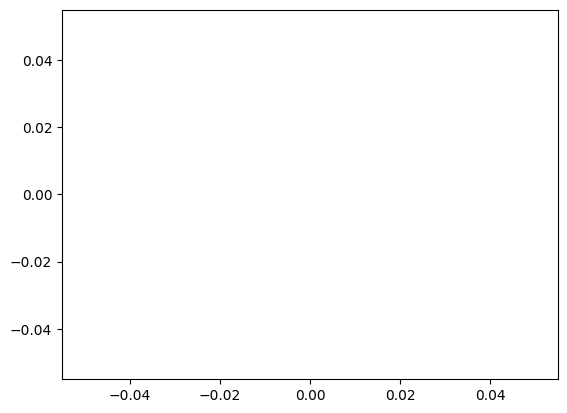

In [256]:
#find the answer of question of expert in F1 and finding the correlation with the answer proposed par expert
#besoin des paragraphs !!!!
def find_answer(F1, question, suggestion):
    import pdftotext
    import numpy as np
    from scipy.stats import pearsonr
    from IPython.display import clear_output

    
    pdf_f = open(F1, 'rb')
    pdf = pdftotext.PDF(pdf_f)
    pdf_f.close()
    
    text1 = preprocess(pdf)
    
    from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, strip_non_alphanum, strip_numeric, strip_tags, strip_multiple_whitespaces, stem_text, strip_short
    CUSTOM_FILTERS = [remove_stopwords, strip_non_alphanum, strip_tags, strip_multiple_whitespaces]
    textClean1 = [preprocess_string(line, CUSTOM_FILTERS) for line in text1]
    Q = preprocess_string(question, CUSTOM_FILTERS)
    
    common_texts = textClean1
    
    from gensim.models import RpModel, TfidfModel, LsiModel, LdaModel, HdpModel
    from gensim.corpora import Dictionary
    from gensim.test.utils import temporary_file
    
    dictionary = Dictionary(common_texts)  # fit dictionary
    
    corpus1 = [dictionary.doc2bow(text) for text in textClean1]  # convert texts to BoW format
    
    modelT = TfidfModel(corpus=corpus1, id2word=dictionary)
    corpusT = modelT[corpus1]
    d2bQ = dictionary.doc2bow(Q)
    vecQT = modelT[d2bQ]


    modelTL = LsiModel(corpus=corpusT)  # , id2word=dictionary  fit Lsi model over Tfidf
    corpusTL = modelTL[corpusT]
    vecQTL = modelTL[vecQT]

    from gensim import similarities
    index = similarities.MatrixSimilarity(corpusTL)  # transform corpus to LSI space and index it
    
    sims = index[vecQTL]  # perform a similarity query against the corpus
    sorted_sims = sorted(list(enumerate(sims)), key=lambda item: item[1], reverse=True)
    
    reponse=[]
    s_answer=[]
    
    for doc_position, doc_score in sorted_sims:
        if doc_score > 0.2:
            reponse.append((doc_score, doc_position))
            A = preprocess_string(suggestion, CUSTOM_FILTERS)
            d2bA = dictionary.doc2bow(A)
            vecATL = modelTL[modelT[d2bA]]
            indexA = similarities.MatrixSimilarity(corpusTL)
            simsA = indexA[vecATL]
            s_answer.append(simsA[doc_position])
  

    algAnswer = [(text1[item[1]],item[0]) for item in reponse]
    
   
    len_text1=[len(text) for text in text1]
    len_ctext=[len(ctext) for ctext in common_texts]
    
    print(len_text1,'\n\n\n',len_ctext)
    
    return(len_text1, len_ctext)
    
import glob
from IPython.display import clear_output
len_text=[]
len_ctext=[]
result=[]
alg_answ=[]
dir_name = glob.glob('PATH TO GUIDELINES IN PDF AND TEXT CONTAINING QUESTION AND ANSWERS IN TXT FORMAT')
for item in dir_name:
    for file in glob.glob(item):
        name = file.split('/')[-1]
        F1 = file+'/Dyall_'+name+'.pdf'
        f = open(item+'/'+item.split('/')[-1]+'.txt', 'r', encoding='utf8', errors='ignore')
        lines = f.readlines()
        lines = [line.replace('\n','') for line in lines]
        f.close()
        
   
        question = [lines[num+1] for num,line in enumerate(lines) if ('Clinical question' in line) == True][0][:-1]
        suggestion = [' '.join(lines[num:]) for num,line in enumerate(lines) if ('conclu' in line.lower()) == True][0]
        
        answer = find_answer(F1, question, suggestion)
        
    len_text.append(answer[0])
    len_ctext.append(answer[1])

print('End...')
